In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
from collections import defaultdict

from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from keras import datasets
from tensorflow.python.keras.utils import np_utils

from dsan import MVIDataset
from dsan import Imputer as DSANImputer
from utils import *

In [5]:
class CategoryMapper(object):
    def __init__(self, data, num_vars, cat_vars):
        self.data = data
        self.num_vars = num_vars
        self.cat_vars = cat_vars
        self.columns = data.columns
        self.label_encoders = defaultdict(LabelEncoder)

    def fit_transform(self, data):
        missing = pd.isnull(data.iloc[:, self.cat_vars])
        encode_values = data.iloc[:, self.cat_vars].fillna('NULL')
        encode_values = encode_values.astype('str')
        encode_values = encode_values.apply(
                lambda x: self.label_encoders[x.name].fit_transform(x)
                )
        encode_values = encode_values.values.astype('float')
        encode_values[missing] = np.nan
        data.iloc[:, self.cat_vars] = encode_values
        return data

    def fit(self, data):
        missing = pd.isnull(data.iloc[:, self.cat_vars])
        encode_values = data.iloc[:, self.cat_vars].fillna('NULL')
        encode_values = encode_values.apply(
                lambda x: self.label_encoders[x.name].fit(x)
                )

    def transform(self, data):
        missing = pd.isnull(data.iloc[:, self.cat_vars])
        encode_values = data.iloc[:, self.cat_vars].fillna('NULL')
        encode_values = encode_values.apply(
                lambda x: self.label_encoders[x.name].transform(x)
                )
        encode_values = encode_values.values.astype('float')
        encode_values[missing] = np.nan
        data.iloc[:, self.cat_vars] = encode_values
        return data

    def inverse_transform(self, data):
        data = pd.DataFrame(data, columns=self.columns)
        inverse_values = data.iloc[:, self.cat_vars].astype('int')
        inverse_values = inverse_values.apply(
                lambda x: self.label_encoders[x.name].inverse_transform(x)
                )
        data.iloc[:, self.cat_vars] = inverse_values.values
        return data

In [6]:
def keras_classifier(df, test_idxs):
    df['heart_risk10'] = np.where(df['heart_risk10'] < 0.3, 0, 1)
    feature_columns = [tf.feature_column.numeric_column(col) for col in df.columns[:-1]]

    def create_ds(df, trainset=True):
        df = df.copy()
        labels = df.pop('heart_risk10')
        if trainset:
            return tf.data.Dataset.from_tensor_slices((dict(df), labels)).shuffle(buffer_size=len(df)).batch(32)
        else:
            return tf.data.Dataset.from_tensor_slices((dict(df), labels)).batch(32)

    n_sample = df.shape[0]
    train_idxs = sorted(set(range(n_sample)) - set(test_idxs))
    train = df.loc[train_idxs, :]
    test = df.loc[test_idxs, :]

    train_ds = create_ds(train)
    test_ds = create_ds(test, trainset=False)

    model = tf.keras.models.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns = feature_columns),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=test_ds, epochs=5, use_multiprocessing=True)

    predictions = model.predict(test_ds)
    bin_predictions = tf.round(predictions).numpy().flatten()

    acc = accuracy_score(test['heart_risk10'].values, bin_predictions)
    f1 = f1_score(test['heart_risk10'].values, bin_predictions)

    print('### Confusion Matrix ###')
    print(confusion_matrix(test['heart_risk10'].values, bin_predictions))
    print(classification_report(test['heart_risk10'].values,bin_predictions))

    print(f'Accuracy: {round(acc, 4)}')
    print(f'F1 Score: {round(f1, 4)}')
    return model, history

In [7]:
def count_mvs(data):
    na_count = data.isnull().sum().sum()
    total_count = data.shape[0] * data.shape[1]
    missing_rate = round(na_count / total_count * 100, 4)
    print(f'Total Missing Values: {na_count}')
    print(f'Missing percent: {missing_rate} %')

In [8]:
seed = 128
set_seed(seed)
tf.random.set_seed(seed)

data = pd.read_csv('/content/health_raw.csv')
data = data.iloc[:, 1:]

num_vars = data.dtypes[data.dtypes == 'float'].index
num_vars = [data.columns.get_loc(idx) for idx in num_vars]
num_vars.append(1)
num_vars.append(84)
num_vars.sort()

n_col = data.shape[1]
cat_vars = list(set(range(n_col)) - set(num_vars))
columns = data.columns

n_sample = data.shape[0]
n_test = int(0.2 * n_sample)
test_idxs = sorted(random.sample(range(n_sample), n_test))

In [9]:
print('num of records: ', data.shape[0])
print('num of columns: ', data.shape[1])

num of records:  101500
num of columns:  98


In [10]:
data.head()

,sex,age,cva,htn,lip,dm,dep,schizo,bipol,anx,insom,alch,stress,asth2,fhtnyn,fcvayn,flipyn,fbipolyn,fschizoyn,fanxyn,finsomyn,falchyn,fstressyn,fdepyn,fdmyn,fasthyn,jb_irelay,sd_idr2,sd_idr3,income,edu,Coffee,coff_sugar,coff_cream,greentea,softdrink,etcdrink,menyn,hrtyn,exerfq,DXA_total_tscore,HeartRate,FVC,FEV1,FEF25_75,PEF,FVC__exp,FEV1__exp,FEF25_75__exp,PEF__exp,Imp_muscle,Imp_fat,hsCRP,FBS,FBInsulin,Hb_A1c,Protein,Albumin,Creatinine,Calcium,AST,ALT,rGTP,UricAcid,TSH,tCholesterol,HDL,LDL,triglyceride,WBC,RBC,Hemoglobin,Platelet,Height,Weight,Waist,Hip,SBP,DBP,ces_dep,marry_yn,snoring_yn,smoker_yn,DRINK_yn,walk,packyear,calorie_intake,carbo_intake,lipid_intake,lipid_plant,lipid_animal,prot_intake,fiber_intake,bmi,lung_risk10,colo_risk10,dia_risk10,heart_risk10
0,2,29,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,NaN,NaN,NaN,13.0,1.3,1.7,1.1,NaN,0.2,NaN,2,1,3.0,NaN,56.0,4.0,3.2,3.4,6.2,90.0,99.0,132.0,80.0,13.1,9.7,2.0,86.0,2.6,5.5,8.7,5.5,0.8,10.8,10.0,9.0,39.6,5.5,1.0,191.2,40.8,62.8,41.8,6.6,5.2,12.0,323.8,155.9,64.4,69.8,85.6,67.0,65.0,25.0,2,2,1,1,1800,NaN,554.6,309.6,31.8,14.0,8.0,47.0,8.6,26.4,0.000000,0.011559,0.094320,0.175325
1,2,37,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2.0,5.0,600.0,11.0,0.8,1.1,0.5,NaN,1.1,NaN,1,1,NaN,1.4,61.0,4.8,3.0,4.0,6.2,100.0,76.0,66.0,120.0,23.9,12.5,0.6,110.0,11.3,5.9,7.5,4.7,1.2,8.8,12.0,21.0,11.2,4.6,4.0,182.1,35.0,49.2,122.2,4.2,3.8,8.8,493.0,166.7,69.6,82.2,90.4,126.0,82.0,9.0,2,2,1,2,16200,NaN,1335.0,382.8,85.4,39.0,30.4,47.0,65.2,25.0,0.000000,0.163458,0.336127,0.160429
2,2,32,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1.0,3.0,176.0,19.0,1.3,1.0,0.2,0.6,NaN,0.6,1,1,NaN,0.4,89.0,3.4,2.2,4.4,8.4,119.0,129.0,35.0,55.0,42.3,9.5,4.4,123.0,8.4,NaN,7.6,4.5,0.4,10.3,22.0,15.0,18.2,3.2,1.2,217.7,64.6,133.2,18.6,9.6,4.2,12.8,221.6,155.1,43.8,64.4,84.6,140.0,82.0,19.0,2,1,1,2,1800,NaN,1131.2,41.0,88.4,0.2,41.0,71.8,3.6,18.2,0.081590,0.123890,0.163300,0.260328
3,1,20,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1.0,3.0,NaN,12.0,NaN,NaN,NaN,NaN,1.5,NaN,1,1,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.6,11.4,8.0,120.0,13.0,4.3,8.3,5.0,1.2,10.0,25.0,19.0,31.6,8.3,1.8,171.4,80.0,63.0,50.4,8.2,5.6,14.8,316.8,177.9,66.3,74.6,96.6,124.0,79.0,11.0,1,1,2,2,6000,99.0,3516.8,633.6,2.6,3.4,32.2,73.0,14.0,21.0,0.103175,0.236204,0.179487,0.242424
4,1,29,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,NaN,NaN,336.0,13.0,0.7,NaN,NaN,1.0,1.0,0.9,1,1,NaN,2.8,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.6,2.1,3.2,105.0,6.6,5.0,6.5,4.4,1.0,9.2,47.0,21.0,19.4,7.1,0.4,237.7,44.6,31.8,NaN,5.4,4.4,16.2,174.0,190.5,77.7,93.4,100.8,98.0,76.0,20.0,1,1,1,1,1800,NaN,71.4,246.6,142.4,17.6,24.6,100.8,18.6,21.4,0.026066,0.007025,0.345936,0.084718


In [11]:
na_idx = (data.isnull().sum() != 0)
n_record = data.shape[0]
for col, na_c in data.isnull().sum()[na_idx].items():
    print(f"""
    column name: {col}
    missing values: {na_c}
    missing percent: {round(na_c/n_record * 100, 4)} %
    """)


    column name: sd_idr2 
    missing values: 37731
    missing percent: 37.1734 %
    

    column name: sd_idr3 
    missing values: 37731
    missing percent: 37.1734 %
    

    column name: income 
    missing values: 9570
    missing percent: 9.4286 %
    

    column name: edu 
    missing values: 261
    missing percent: 0.2571 %
    

    column name: Coffee 
    missing values: 13891
    missing percent: 13.6857 %
    

    column name: coff_sugar 
    missing values: 33118
    missing percent: 32.6286 %
    

    column name: coff_cream 
    missing values: 42659
    missing percent: 42.0286 %
    

    column name: greentea 
    missing values: 31581
    missing percent: 31.1143 %
    

    column name: softdrink 
    missing values: 47299
    missing percent: 46.6 %
    

    column name: etcdrink 
    missing values: 35148
    missing percent: 34.6286 %
    

    column name: exerfq 
    missing values: 66990
    missing percent: 66.0 %
    

    column name: DXA_total_t

In [12]:
count_mvs(data)

Total Missing Values: 553028
Missing percent: 5.5597 %


In [13]:
# statistic imputation
class StatImputer(object):
    def __init__(self):
        return

    def fit_transform(self, X_incomplete, cat_vars):
        vars = set(range(X_incomplete.shape[1]))
        num_vars = list(vars - set(cat_vars))

        df = pd.DataFrame(X_incomplete)
        means = df.iloc[:, num_vars].mean()
        df.fillna(value=means, inplace=True)

        modes = df.iloc[:, cat_vars].mode()
        mode_dict = dict()
        for v in cat_vars:
            mode_dict[v] = modes[v][0]
        df.fillna(value=mode_dict, inplace=True)
        return df.values

imputer = StatImputer()
X_stat = imputer.fit_transform(data.values, cat_vars=cat_vars)
df_stat = pd.DataFrame(X_stat, columns=columns)
df_stat.iloc[:, cat_vars] = df_stat.iloc[:, cat_vars].astype('int')

In [14]:
df_stat.head()

,sex,age,cva,htn,lip,dm,dep,schizo,bipol,anx,insom,alch,stress,asth2,fhtnyn,fcvayn,flipyn,fbipolyn,fschizoyn,fanxyn,finsomyn,falchyn,fstressyn,fdepyn,fdmyn,fasthyn,jb_irelay,sd_idr2,sd_idr3,income,edu,Coffee,coff_sugar,coff_cream,greentea,softdrink,etcdrink,menyn,hrtyn,exerfq,DXA_total_tscore,HeartRate,FVC,FEV1,FEF25_75,PEF,FVC__exp,FEV1__exp,FEF25_75__exp,PEF__exp,Imp_muscle,Imp_fat,hsCRP,FBS,FBInsulin,Hb_A1c,Protein,Albumin,Creatinine,Calcium,AST,ALT,rGTP,UricAcid,TSH,tCholesterol,HDL,LDL,triglyceride,WBC,RBC,Hemoglobin,Platelet,Height,Weight,Waist,Hip,SBP,DBP,ces_dep,marry_yn,snoring_yn,smoker_yn,DRINK_yn,walk,packyear,calorie_intake,carbo_intake,lipid_intake,lipid_plant,lipid_animal,prot_intake,fiber_intake,bmi,lung_risk10,colo_risk10,dia_risk10,heart_risk10
0,2.0,29.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.371387,4.480296,382.945274,13.0,1.300000,1.700000,1.100000,1.050181,0.200000,0.970616,2.0,1.0,3.000000,1.463549,56.0,4.000000,3.200000,3.400000,6.200000,90.000000,99.000000,132.000000,80.000000,13.1,9.7,2.0,86.0,2.6,5.500000,8.7,5.5,0.8,10.8,10.0,9.0,39.6,5.5,1.0,191.2,40.8,62.8,41.800000,6.6,5.2,12.0,323.8,155.9,64.4,69.8,85.6,67.0,65.0,25.0,2.0,2.0,1.0,1.0,1800.0,316.169979,554.6,309.6,31.8,14.0,8.0,47.0,8.6,26.4,0.000000,0.011559,0.094320,0.175325
1,2.0,37.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,5.000000,600.000000,11.0,0.800000,1.100000,0.500000,1.050181,1.100000,0.970616,1.0,1.0,4.198551,1.400000,61.0,4.800000,3.000000,4.000000,6.200000,100.000000,76.000000,66.000000,120.000000,23.9,12.5,0.6,110.0,11.3,5.900000,7.5,4.7,1.2,8.8,12.0,21.0,11.2,4.6,4.0,182.1,35.0,49.2,122.200000,4.2,3.8,8.8,493.0,166.7,69.6,82.2,90.4,126.0,82.0,9.0,2.0,2.0,1.0,2.0,16200.0,316.169979,1335.0,382.8,85.4,39.0,30.4,47.0,65.2,25.0,0.000000,0.163458,0.336127,0.160429
2,2.0,32.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,3.000000,176.000000,19.0,1.300000,1.000000,0.200000,0.600000,0.979266,0.600000,1.0,1.0,4.198551,0.400000,89.0,3.400000,2.200000,4.400000,8.400000,119.000000,129.000000,35.000000,55.000000,42.3,9.5,4.4,123.0,8.4,5.467276,7.6,4.5,0.4,10.3,22.0,15.0,18.2,3.2,1.2,217.7,64.6,133.2,18.600000,9.6,4.2,12.8,221.6,155.1,43.8,64.4,84.6,140.0,82.0,19.0,2.0,1.0,1.0,2.0,1800.0,316.169979,1131.2,41.0,88.4,0.2,41.0,71.8,3.6,18.2,0.081590,0.123890,0.163300,0.260328
3,1.0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,3.000000,382.945274,12.0,1.087215,0.853694,0.822666,1.050181,1.500000,0.970616,1.0,1.0,4.198551,1.463549,72.0,3.667602,2.954633,3.105509,7.310154,98.557767,103.733017,93.520318,105.912085,40.6,11.4,8.0,120.0,13.0,4.300000,8.3,5.0,1.2,10.0,25.0,19.0,31.6,8.3,1.8,171.4,80.0,63.0,50.400000,8.2,5.6,14.8,316.8,177.9,66.3,74.6,96.6,124.0,79.0,11.0,1.0,1.0,2.0,2.0,6000.0,99.000000,3516.8,633.6,2.6,3.4,32.2,73.0,14.0,21.0,0.103175,0.236204,0.179487,0.242424
4,1.0,29.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.371387,4.480296,336.000000,13.0,0.700000,0.853694,0.822666,1.000000,1.000000,0.900000,1.0,1.0,4.198551,2.800000,85.0,3.667602,2.954633,3.105509,7.310154,98.557767,103.733017,93.520318,105.912085,24.6,2.1,3.2,105.0,6.6,5.000000,6.5,4.4,1.0,9.2,47.0,21.0,19.4,7.1,0.4,237.7,44.6,31.8,121.903341,5.4,4.4,16.2,174.0,190.5,77.7,93.4,100.8,98.0,76.0,20.0,1.0,1.0,1.0,1.0,1800.0,316.169979,71.4,246.6,142.4,17.6,24.6,100.8,18.6,21.4,0.026066,0.007025,0.345936,0.084718


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Epoch 1/5
2538/2538 [==============================] - 47s 14ms/step - loss: 18.2170 - accuracy: 0.5847 - val_loss: 1.1834 - val_accuracy: 0.6519
Epoch 2/5
2538/2538 [==============================] - 33s 12ms/step - loss: 0.5937 - accuracy: 0.7033 - val_loss: 0.4722 - val_accuracy: 0.7933
Epoch 3/5
2538/2538 [==============================] - 32s 11ms/step - loss: 0.5309 - accuracy: 0.7268 - val_loss: 0.5534 - val_accuracy: 0.6983
Epoch 4/5
2538/2538 [==============================] - 33s 12ms/step - loss: 0.5034 - accuracy: 0.7567 - val_loss: 0.4418 - val_accuracy: 0.8175
Epoch 5/5
635/635 [==============================] - 6s 9ms/step
### Confusion Matrix ###
[[6305 3355]
 [1189 9451]]
              precision    recall  f1-score   support

           0       0.84      0.65      0.74      9660
           1       0.74      0.89      0.81     10640

    accuracy                           0.78     20300
   macro avg       0.79      0.77      0.77     20300
weighted avg       0.79      0

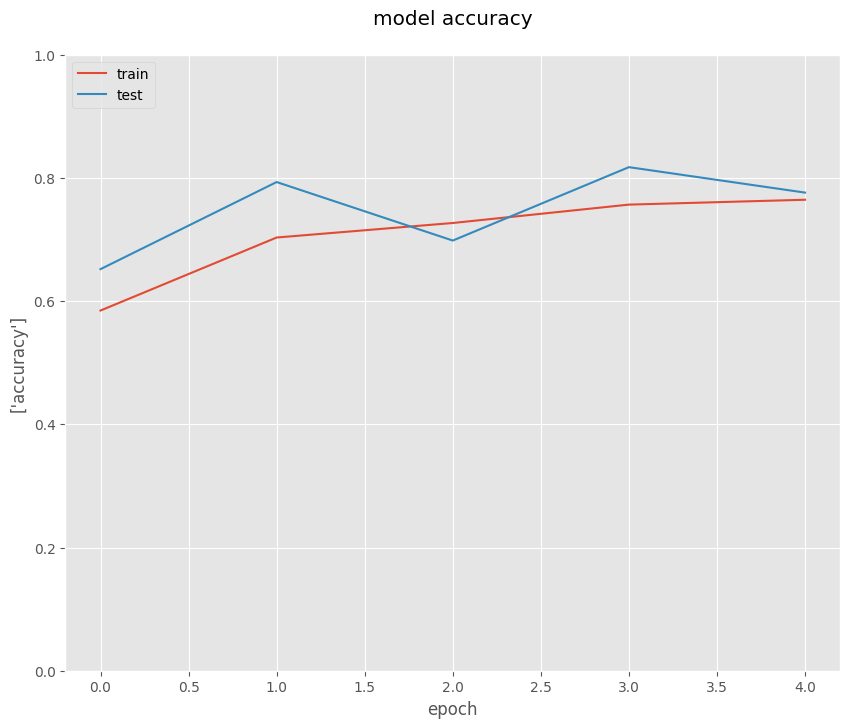

In [15]:
model, history = keras_classifier(df_stat, test_idxs)

plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy\n')
plt.ylabel(['accuracy'])
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train','test'],loc='upper left')
plt.show()

In [16]:
imputer = DSANImputer(rep_dim=16,
                      num_heads=4,
                      n_hidden=1,
                      dropout=0.3,
                      lr=3e-3,
                      weight_decay=1e-5,
                      batch_size=256,
                      epochs=5,
                      noise_percent=40,
                      stopped_epoch=10)

cm = CategoryMapper(data=data, num_vars=num_vars, cat_vars=cat_vars)
targets = np.isnan(data.values)
X_incomplete = cm.fit_transform(data)
X_imputed = imputer.fit_transform(data.values, cat_vars=cat_vars)
imputed_values = X_incomplete.values
imputed_values[targets] = X_imputed[targets]
df_imputed = pd.DataFrame(imputed_values, columns=columns)
df_imputed = cm.inverse_transform(df_imputed)

100%|██████████| 5/5 [14:56<00:00, 179.23s/it]


In [17]:
df_imputed.head()

,sex,age,cva,htn,lip,dm,dep,schizo,bipol,anx,insom,alch,stress,asth2,fhtnyn,fcvayn,flipyn,fbipolyn,fschizoyn,fanxyn,finsomyn,falchyn,fstressyn,fdepyn,fdmyn,fasthyn,jb_irelay,sd_idr2,sd_idr3,income,edu,Coffee,coff_sugar,coff_cream,greentea,softdrink,etcdrink,menyn,hrtyn,exerfq,DXA_total_tscore,HeartRate,FVC,FEV1,FEF25_75,PEF,FVC__exp,FEV1__exp,FEF25_75__exp,PEF__exp,Imp_muscle,Imp_fat,hsCRP,FBS,FBInsulin,Hb_A1c,Protein,Albumin,Creatinine,Calcium,AST,ALT,rGTP,UricAcid,TSH,tCholesterol,HDL,LDL,triglyceride,WBC,RBC,Hemoglobin,Platelet,Height,Weight,Waist,Hip,SBP,DBP,ces_dep,marry_yn,snoring_yn,smoker_yn,DRINK_yn,walk,packyear,calorie_intake,carbo_intake,lipid_intake,lipid_plant,lipid_animal,prot_intake,fiber_intake,bmi,lung_risk10,colo_risk10,dia_risk10,heart_risk10
0,2,29.0,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1.111464,4.479283,404.604553,13.0,1.300000,1.700000,1.100000,0.969335,0.200000,0.904814,2,1,3.000000,1.404578,56.0,4.000000,3.200000,3.400000,6.200000,90.000000,99.000000,132.000000,80.000000,13.1,9.7,2.0,86.0,2.6,5.500000,8.7,5.5,0.8,10.8,10.0,9.0,39.6,5.5,1.0,191.2,40.8,62.8,41.800000,6.6,5.2,12.0,323.8,155.9,64.4,69.8,85.6,67.0,65.0,25.0,2,2,1,1,1800.0,180.409164,554.6,309.6,31.8,14.0,8.0,47.0,8.6,26.4,0.000000,0.011559,0.094320,0.175325
1,2,37.0,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2.000000,5.000000,600.000000,11.0,0.800000,1.100000,0.500000,1.069448,1.100000,0.928443,1,1,3.806684,1.400000,61.0,4.800000,3.000000,4.000000,6.200000,100.000000,76.000000,66.000000,120.000000,23.9,12.5,0.6,110.0,11.3,5.900000,7.5,4.7,1.2,8.8,12.0,21.0,11.2,4.6,4.0,182.1,35.0,49.2,122.200000,4.2,3.8,8.8,493.0,166.7,69.6,82.2,90.4,126.0,82.0,9.0,2,2,1,2,16200.0,216.768692,1335.0,382.8,85.4,39.0,30.4,47.0,65.2,25.0,0.000000,0.163458,0.336127,0.160429
2,2,32.0,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,3.000000,176.000000,19.0,1.300000,1.000000,0.200000,0.600000,1.028382,0.600000,1,1,4.056288,0.400000,89.0,3.400000,2.200000,4.400000,8.400000,119.000000,129.000000,35.000000,55.000000,42.3,9.5,4.4,123.0,8.4,5.634725,7.6,4.5,0.4,10.3,22.0,15.0,18.2,3.2,1.2,217.7,64.6,133.2,18.600000,9.6,4.2,12.8,221.6,155.1,43.8,64.4,84.6,140.0,82.0,19.0,2,1,1,2,1800.0,208.938248,1131.2,41.0,88.4,0.2,41.0,71.8,3.6,18.2,0.081590,0.123890,0.163300,0.260328
3,1,20.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1.000000,3.000000,445.369843,12.0,1.103058,0.766971,0.690057,1.061354,1.500000,1.004459,1,1,3.559174,1.757325,72.0,4.402423,3.756746,3.672330,8.498391,95.631035,96.343529,101.051285,99.643127,40.6,11.4,8.0,120.0,13.0,4.300000,8.3,5.0,1.2,10.0,25.0,19.0,31.6,8.3,1.8,171.4,80.0,63.0,50.400000,8.2,5.6,14.8,316.8,177.9,66.3,74.6,96.6,124.0,79.0,11.0,1,1,2,2,6000.0,99.000000,3516.8,633.6,2.6,3.4,32.2,73.0,14.0,21.0,0.103175,0.236204,0.179487,0.242424
4,1,29.0,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1.485131,6.604358,336.000000,13.0,0.700000,0.735881,0.784048,1.000000,1.000000,0.900000,1,1,4.148843,2.800000,85.0,4.406339,3.669071,3.559629,8.751182,96.161423,100.954033,93.935387,97.675362,24.6,2.1,3.2,105.0,6.6,5.000000,6.5,4.4,1.0,9.2,47.0,21.0,19.4,7.1,0.4,237.7,44.6,31.8,126.464706,5.4,4.4,16.2,174.0,190.5,77.7,93.4,100.8,98.0,76.0,20.0,1,1,1,1,1800.0,246.996994,71.4,246.6,142.4,17.6,24.6,100.8,18.6,21.4,0.026066,0.007025,0.345936,0.084718


In [18]:
count_mvs(df_imputed)

Total Missing Values: 0
Missing percent: 0.0 %


Epoch 1/5
2538/2538 [==============================] - 42s 13ms/step - loss: 15.8245 - accuracy: 0.5805 - val_loss: 0.6693 - val_accuracy: 0.6494
Epoch 2/5
2538/2538 [==============================] - 34s 12ms/step - loss: 0.6766 - accuracy: 0.6110 - val_loss: 0.6226 - val_accuracy: 0.6016
Epoch 3/5
2538/2538 [==============================] - 34s 12ms/step - loss: 0.5825 - accuracy: 0.6643 - val_loss: 0.5011 - val_accuracy: 0.7782
Epoch 4/5
2538/2538 [==============================] - 33s 12ms/step - loss: 0.5648 - accuracy: 0.6857 - val_loss: 0.4722 - val_accuracy: 0.8002
Epoch 5/5
635/635 [==============================] - 7s 9ms/step
### Confusion Matrix ###
[[6802 2858]
 [1947 8693]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      9660
           1       0.75      0.82      0.78     10640

    accuracy                           0.76     20300
   macro avg       0.77      0.76      0.76     20300
weighted avg       0.76      0

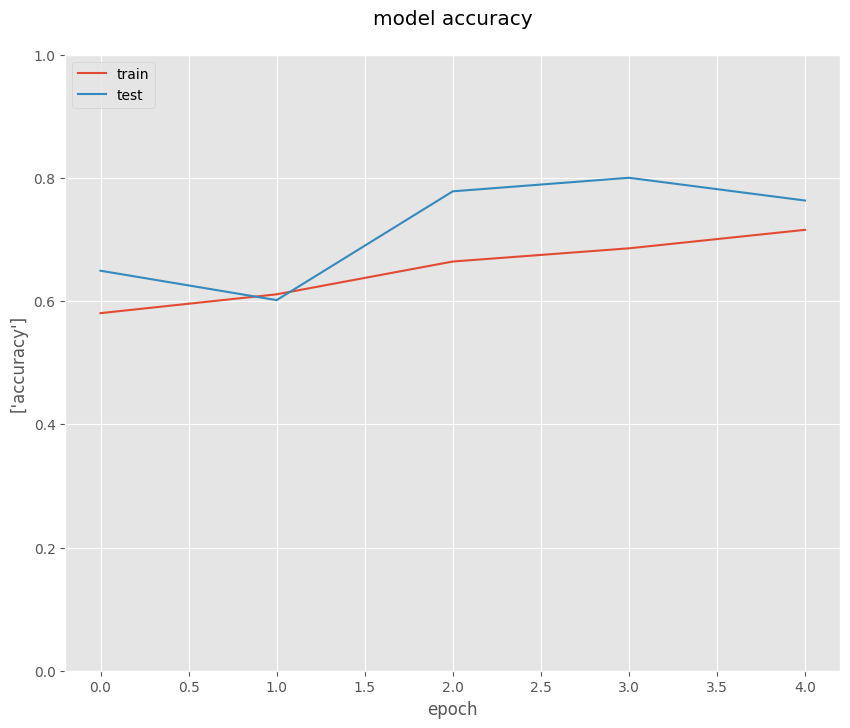

In [19]:
model, history = keras_classifier(df_imputed.astype('float'), test_idxs)

plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy\n')
plt.ylabel(['accuracy'])
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train','test'],loc='upper left')
plt.show()